In [116]:
from bs4 import BeautifulSoup as BS
import requests
import json
import time
import datetime

import pandas as pd
import numpy as np
import datetime

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn           as sns
sns.set_style("darkgrid")
%matplotlib inline

In [17]:
import os

app_id = '9615c816-2fac-4683-bca7-3b94d1958030' 

NEWS_KEY = os.getenv('NEWS_KEY')
api_key = NEWS_KEY

In [18]:
def call_nyt_by_year_and_page(year, page):
    root_url   = 'https://api.nytimes.com/svc/search/v2/articlesearch.json?q=oil,petroleum,naturalgas,energy&sort=newest'
    begin_date = '&begin_date={}0101'.format(str(year))
    end_date   = '&end_date={}1231'.format(str(year))
    pagination = '&page={}'.format(str(page))
    doc_params = '&fl=web_url&fl=snippet&fl=pub_date&fl=_id&fl=lead_paragraph%&fl=abstract'
    
    url        = root_url + begin_date + end_date + pagination + doc_params + '&api-key=' + api_key
    print(url)
    
    response   = requests.get(url)
    
    return response.json()

In [7]:
def call_nyt_by_year(year):
    annual_articles = []
    
    # find how many articles (hits) contain 'oil' in a calendar year
    total_results = call_nyt_by_year_and_page(year,0)
    hits  = total_results['response']['meta']['hits']
    
    # request all available pages
    # sleep 7 seconds to clear NYT API rate limit
    for i in range(int(hits/10)):
        query = call_nyt_by_year_and_page(year,i)
        annual_articles = annual_articles + query['response']['docs']
        time.sleep(7)
        
    return annual_articles

In [8]:
def call_nyt_by_all_years(years):
    all_articles = []
    
    for year in years:
        annual_articles = call_nyt_by_year(year)
        all_articles = all_articles + annual_articles
        time.sleep(7)
        
    return all_articles



In [9]:
all_years    = list(range(2010,2020))
all_articles = call_nyt_by_all_years(all_years)

TypeError: can only concatenate str (not "NoneType") to str

In [7]:
# save and read JSON with raw API results
with open("nyt_api.json", "w") as write_file:
    json.dump(all_articles, write_file)
    
with open("nyt_api.json", "r") as read_file:
    data = json.load(read_file)

In [8]:
# web scrape NYT for all articles containing 'tesla' using web URLs from API
# returns article content as string
def get_nyt_text(url):
    # get web URL HTML
    headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}
    page = requests.get(url, headers=headers,timeout=5)
    page.status_code
    
    # get article content from HTML
    soup = BS(page.content, 'html.parser')
    content = soup.findAll('p', class_ = 'css-18icg9x evys1bk0')
    
    nyt = ''
    for index in range(len(content)):
        nyt += content[index].get_text()
        
    return nyt

In [12]:
si = SentimentIntensityAnalyzer()

for i in range(len(data)):
    data[i]['VADER snippet neg']      = si.polarity_scores(data[i]['snippet'])['neg']
    data[i]['VADER snippet neu']      = si.polarity_scores(data[i]['snippet'])['neu']
    data[i]['VADER snippet pos']      = si.polarity_scores(data[i]['snippet'])['pos']
    data[i]['VADER snippet compound'] = si.polarity_scores(data[i]['snippet'])['compound']
    
#     data[i]['VADER lead neg']      = si.polarity_scores(data[i]['lead_paragraph'])['neg']
#     data[i]['VADER lead neu']      = si.polarity_scores(data[i]['lead_paragraph'])['neu']
#     data[i]['VADER lead pos']      = si.polarity_scores(data[i]['lead_paragraph'])['pos']
#     data[i]['VADER lead compound'] = si.polarity_scores(data[i]['lead_paragraph'])['compound']

In [17]:
data[0:3]

[{'abstract': 'It was a year full of big environmental news, from the BP oil spill to the failed climate bill.',
  'web_url': 'https://green.blogs.nytimes.com/2010/12/31/2010-an-untameable-spill-an-unpassable-bill/',
  'snippet': 'It was a year full of big environmental news, from the BP oil spill to the failed climate bill.',
  'pub_date': '2010-12-31T23:00:27+0000',
  '_id': 'nyt://article/6932d941-5087-54fd-a1ac-9b625bd96a6e',
  'article': '',
  'VADER snippet neg': 0.163,
  'VADER snippet neu': 0.837,
  'VADER snippet pos': 0.0,
  'VADER snippet compound': -0.5106},
 {'abstract': 'The first federal regulations on climate-altering gases from factories and power plants take effect on Sunday and set up a dangerous political clash for both sides.',
  'web_url': 'https://www.nytimes.com/2010/12/31/science/earth/31epa.html',
  'snippet': 'The first federal regulations on climate-altering gases from factories and power plants take effect on Sunday and set up a dangerous political clash fo

In [16]:
# save JSON with VADER and TextBlob natural language processing results
with open("nyt_api_and_articles_vader_textblob.json", "w") as write_file:
    json.dump(data, write_file)

In [18]:
# count all web URLs where web scraping could not retrieve article content
null_articles = 0
full_articles = 0

for i in range(len(data)):
    
    if len(data[i]['article']) == 0:
        null_articles += 1
    else:
        full_articles += 1

KeyError: 'article'

In [80]:
sentiment = pd.DataFrame(data)
sentiment['date'] = pd.to_datetime(sentiment.pub_date).dt.date
# sentiment.head()

# turned dataframe to pickle to save information
sentiment.to_pickle("sentiment_pickle.pkl")
sentiment = pd.read_pickle("sentiment_pickle.pkl")
sentiment.head()

In [61]:
# remove records where article content could not be retrieved from web URLs
sentiment_clean = sentiment[sentiment['VADER snippet compound'] != 0]
sentiment_clean.head()

,abstract,web_url,snippet,pub_date,_id,article,VADER snippet neg,VADER snippet neu,VADER snippet pos,VADER snippet compound,date
0,"It was a year full of big environmental news, ...",https://green.blogs.nytimes.com/2010/12/31/201...,"It was a year full of big environmental news, ...",2010-12-31T23:00:27+0000,nyt://article/6932d941-5087-54fd-a1ac-9b625bd9...,,0.163,0.837,0.000,-0.5106,2010-12-31
1,The first federal regulations on climate-alter...,https://www.nytimes.com/2010/12/31/science/ear...,The first federal regulations on climate-alter...,2010-12-31T01:47:00+0000,nyt://article/3cc71f15-7131-58f9-b561-81115150...,,0.114,0.886,0.000,-0.4767,2010-12-31
2,About $11 billion in oil and natural gas trade...,https://www.nytimes.com/2010/12/31/business/gl...,About $11 billion in oil and natural gas trade...,2010-12-30T20:21:30+0000,nyt://article/d8808e92-9912-50bf-b1f4-efd46aef...,,0.072,0.847,0.081,0.0772,2010-12-30
3,"Recent years have been humbling for oil bulls,...",https://www.nytimes.com/2010/12/30/business/30...,"Recent years have been humbling for oil bulls,...",2010-12-30T02:34:46+0000,nyt://article/a3ab7378-223e-5c33-a8bd-48da47e0...,,0.000,0.868,0.132,0.5640,2010-12-30
4,Crude oil traded over $90 for a fifth consecut...,https://www.nytimes.com/2010/12/30/business/30...,Crude oil traded over $90 for a fifth consecut...,2010-12-29T14:06:12+0000,nyt://article/8cf8d370-fd0b-5889-a8af-3745ada9...,,0.215,0.785,0.000,-0.6369,2010-12-29


In [77]:
vader_pickle = sentiment[sentiment['VADER snippet compound'] != 0]
vader_pickle.to_pickle("vader_picke_file.pkl")

In [54]:
# id_column = sentiment['_id']
# id_column.head()
sentiment.columns

Index(['VADER snippet neg', 'VADER snippet neu', 'VADER snippet pos',
       'VADER snippet compound'],
      dtype='object')

In [58]:
# group articles by date
sentiment_clean = sentiment_clean.groupby('date').mean()
sentiment_clean

,VADER snippet neg,VADER snippet neu,VADER snippet pos,VADER snippet compound
date,,,,
2010-01-04,0.198,0.6500,0.1530,-0.3818
2010-01-05,0.000,0.8070,0.1930,0.6369
2010-01-06,0.000,0.8980,0.1020,0.1531
2010-01-07,0.066,0.7020,0.2310,0.6124
2010-01-13,0.000,0.6785,0.3215,0.6564
...,...,...,...,...
2019-12-05,0.135,0.7870,0.0790,-0.3612
2019-12-11,0.000,0.6960,0.3040,0.7178
2019-12-12,0.264,0.6420,0.0950,-0.7184


In [62]:

# get article counts by date
counts = sentiment_clean.groupby('date').count()
counts['article count'] = counts['_id']
counts = counts[['article count']]
counts

,article count
date,
2010-01-04,1
2010-01-05,1
2010-01-06,1
2010-01-07,1
2010-01-13,2
...,...
2019-12-05,1
2019-12-11,1
2019-12-12,1


In [64]:
# group articles by date
sentiment_clean = sentiment_clean.groupby('date').mean()
sentiment_clean

,VADER snippet neg,VADER snippet neu,VADER snippet pos,VADER snippet compound
date,,,,
2010-01-04,0.198,0.6500,0.1530,-0.3818
2010-01-05,0.000,0.8070,0.1930,0.6369
2010-01-06,0.000,0.8980,0.1020,0.1531
2010-01-07,0.066,0.7020,0.2310,0.6124
2010-01-13,0.000,0.6785,0.3215,0.6564
...,...,...,...,...
2019-12-05,0.135,0.7870,0.0790,-0.3612
2019-12-11,0.000,0.6960,0.3040,0.7178
2019-12-12,0.264,0.6420,0.0950,-0.7184


In [65]:
sentiment_counts = sentiment_clean.merge(counts, left_on='date', right_index=True)
sentiment_counts

,VADER snippet neg,VADER snippet neu,VADER snippet pos,VADER snippet compound,article count
date,,,,,
2010-01-04,0.198,0.6500,0.1530,-0.3818,1
2010-01-05,0.000,0.8070,0.1930,0.6369,1
2010-01-06,0.000,0.8980,0.1020,0.1531,1
2010-01-07,0.066,0.7020,0.2310,0.6124,1
2010-01-13,0.000,0.6785,0.3215,0.6564,2
...,...,...,...,...,...
2019-12-05,0.135,0.7870,0.0790,-0.3612,1
2019-12-11,0.000,0.6960,0.3040,0.7178,1
2019-12-12,0.264,0.6420,0.0950,-0.7184,1


In [66]:
sentiment_counts.to_pickle("sentiment_counts.pkl")

In [67]:
# review final DataFrame
sentiment_counts = pd.read_pickle("sentiment_counts.pkl")
sentiment_counts.head()

,VADER snippet neg,VADER snippet neu,VADER snippet pos,VADER snippet compound,article count
date,,,,,
2010-01-04,0.198,0.6500,0.1530,-0.3818,1
2010-01-05,0.000,0.8070,0.1930,0.6369,1
2010-01-06,0.000,0.8980,0.1020,0.1531,1
2010-01-07,0.066,0.7020,0.2310,0.6124,1
2010-01-13,0.000,0.6785,0.3215,0.6564,2


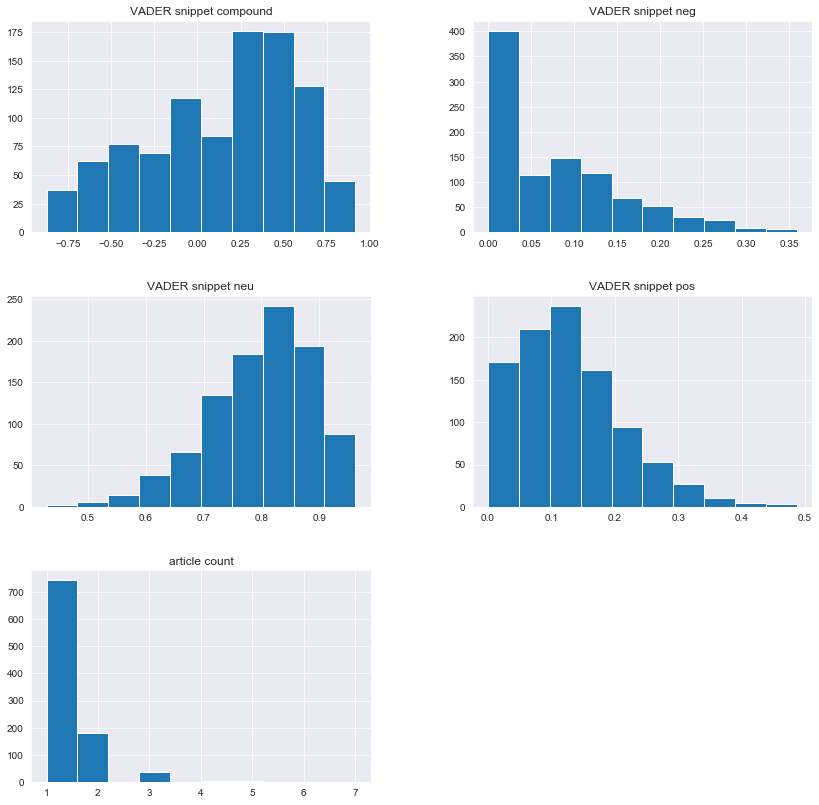

In [68]:
# plot statistical distributions of article sentiment
import matplotlib.pyplot as plt
axes = sentiment_counts.hist(figsize=(14,14))

In [71]:
!pip install spacy
# python -m spacy download en_core_web_sm

     |████████████████████████████████| 14.2MB 17.7MB/s eta 0:00:01
     |████████████████████████████████| 61kB 12.0MB/s eta 0:00:01
     |████████████████████████████████| 3.0MB 19.9MB/s eta 0:00:01
     |████████████████████████████████| 4.0MB 16.9MB/s eta 0:00:01
     |████████████████████████████████| 276kB 24.8MB/s eta 0:00:01
     |████████████████████████████████| 215kB 18.9MB/s eta 0:00:01


In [74]:
import spacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

In [ ]:
doc = npl(text)

[x for x in doc]

for i in range(len(data)):
    data[i]['VADER snippet neg']      = si.polarity_scores(data[i]['snippet'])['neg']
    data[i]['VADER snippet neu']      = si.polarity_scores(data[i]['snippet'])['neu']
    data[i]['VADER snippet pos']      = si.polarity_scores(data[i]['snippet'])['pos']
    data[i]['VADER snippet compound'] = si.polarity_scores(data[i]['snippet'])['compound']
    

In [99]:
sentiment = pd.read_pickle("sentiment_pickle.pkl")
sentiment.head()

,abstract,web_url,snippet,pub_date,_id,article,VADER snippet neg,VADER snippet neu,VADER snippet pos,VADER snippet compound,date
0,"It was a year full of big environmental news, ...",https://green.blogs.nytimes.com/2010/12/31/201...,"It was a year full of big environmental news, ...",2010-12-31T23:00:27+0000,nyt://article/6932d941-5087-54fd-a1ac-9b625bd9...,,0.163,0.837,0.000,-0.5106,2010-12-31
1,The first federal regulations on climate-alter...,https://www.nytimes.com/2010/12/31/science/ear...,The first federal regulations on climate-alter...,2010-12-31T01:47:00+0000,nyt://article/3cc71f15-7131-58f9-b561-81115150...,,0.114,0.886,0.000,-0.4767,2010-12-31
2,About $11 billion in oil and natural gas trade...,https://www.nytimes.com/2010/12/31/business/gl...,About $11 billion in oil and natural gas trade...,2010-12-30T20:21:30+0000,nyt://article/d8808e92-9912-50bf-b1f4-efd46aef...,,0.072,0.847,0.081,0.0772,2010-12-30
3,"Recent years have been humbling for oil bulls,...",https://www.nytimes.com/2010/12/30/business/30...,"Recent years have been humbling for oil bulls,...",2010-12-30T02:34:46+0000,nyt://article/a3ab7378-223e-5c33-a8bd-48da47e0...,,0.000,0.868,0.132,0.5640,2010-12-30
4,Crude oil traded over $90 for a fifth consecut...,https://www.nytimes.com/2010/12/30/business/30...,Crude oil traded over $90 for a fifth consecut...,2010-12-29T14:06:12+0000,nyt://article/8cf8d370-fd0b-5889-a8af-3745ada9...,,0.215,0.785,0.000,-0.6369,2010-12-29


In [100]:
# clean dataframe to show only date and sentiment compound score
sentiment_compound = sentiment.drop(columns=['abstract', 'web_url', 'snippet', 'pub_date', '_id', 'article', 'VADER snippet neg', 'VADER snippet neu', 'VADER snippet pos'])
sentiment_compound

,VADER snippet compound,date
0,-0.5106,2010-12-31
1,-0.4767,2010-12-31
2,0.0772,2010-12-30
3,0.5640,2010-12-30
4,-0.6369,2010-12-29
...,...,...
1515,-0.6705,2019-02-04
1516,0.5994,2019-02-03
1517,0.1027,2019-01-27
1518,0.4215,2019-01-25


In [101]:
# import crude oil prices from csv
from pathlib import Path

crude_oil_path = "crude_oil.csv"
crude_oil_prices = pd.read_csv(crude_oil_path)

In [102]:
crude_oil_prices.set_index('date', inplace=True)
crude_oil_prices.index = pd.to_datetime(crude_oil_prices.index)

crude_oil_prices.head()

,value
date,
2010-02-09,73.71
2010-02-10,74.48
2010-02-11,75.23
2010-02-12,74.11
2010-02-16,76.98


In [103]:
# get sentiment average per day
average = sentiment_compound.groupby('date').mean()
average['VADER avg'] = average['VADER snippet compound']
average = average[['VADER avg']]
average

,VADER avg
date,
2010-01-04,-0.38180
2010-01-05,0.31845
2010-01-06,0.15310
2010-01-07,0.61240
2010-01-13,0.65640
...,...
2019-12-12,-0.71840
2019-12-13,0.00000
2019-12-16,0.00000


In [104]:
average.index = pd.to_datetime(average.index)
average.head()

,VADER avg
date,
2010-01-04,-0.38180
2010-01-05,0.31845
2010-01-06,0.15310
2010-01-07,0.61240
2010-01-13,0.65640


In [112]:
# sentiment_counts = sentiment_clean.merge(counts, left_on='date', right_index=True)
merged = crude_oil_prices.merge(average, left_index=True, right_index=True)

merged

,value,VADER avg
date,,
2010-02-09,73.710,0.000000
2010-02-10,74.480,0.624900
2010-02-11,75.230,0.778300
2010-02-16,76.980,0.651767
2010-02-17,77.270,0.659700
...,...,...
2019-12-12,59.180,-0.718400
2019-12-13,60.070,0.000000
2019-12-16,60.196,0.000000


In [113]:
daily_changes = merged[' value'].pct_change()


In [115]:
merged['daily_changes'] = daily_changes
merged

,value,VADER avg,daily_changes
date,,,
2010-02-09,73.710,0.000000,NaN
2010-02-10,74.480,0.624900,0.010446
2010-02-11,75.230,0.778300,0.010070
2010-02-16,76.980,0.651767,0.023262
2010-02-17,77.270,0.659700,0.003767
...,...,...,...
2019-12-12,59.180,-0.718400,0.007148
2019-12-13,60.070,0.000000,0.015039
2019-12-16,60.196,0.000000,0.002098


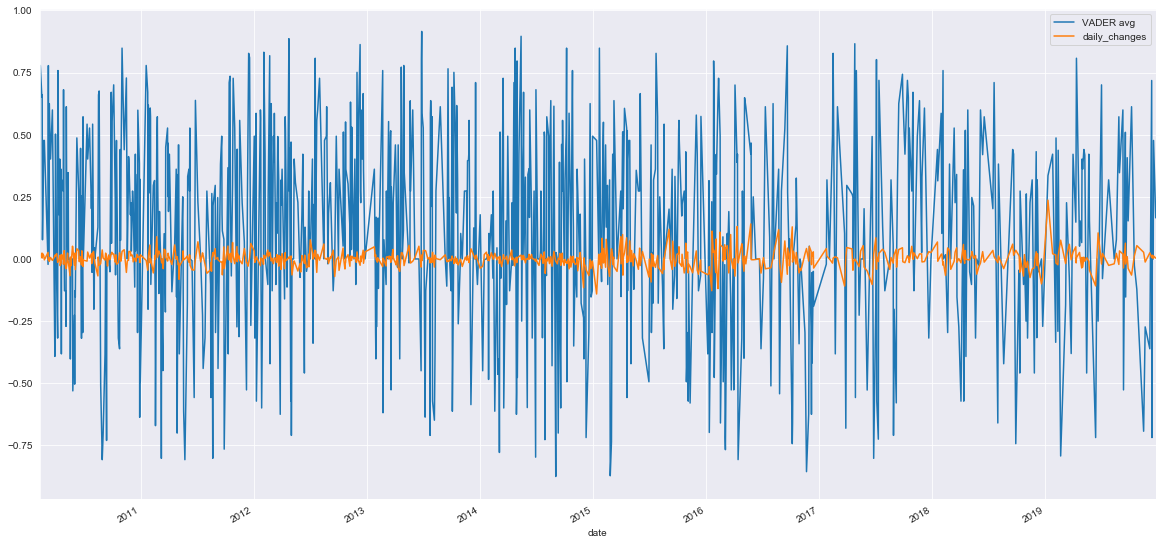

In [122]:
merged[['VADER avg', 'daily_changes']].plot(figsize=(20,10))

In [123]:
correlation = merged.corr()

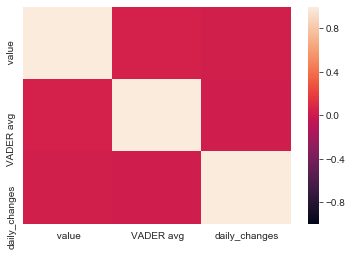

In [124]:
sns.heatmap(correlation, vmin=-1, vmax=1)